## Linear Regression & Regularization from Scratch - Oded Ben Chetrit 



### Import Boston Dataset:

In [1]:
import numpy as np
import sklearn
import sklearn.datasets
import matplotlib.pyplot as plt
plt.style.use("bmh")

# importing the Boston dataset: 
X, y = sklearn.datasets.load_boston(return_X_y = True)

# number of samples: 
n = X.shape[0]

# number of features/dimentions: 
p = X.shape[1]

print(f'P is: {p+1} after padding, and N is: {n}')

P is: 14 after padding, and N is: 506


### Ols Class - Ordinary Least Square model:
The model is $\hat{y}=X\cdot w$ where we assume for simplicity that $X$'s first columns equals to 1 (one padding), to account for the bias term.

Our objective is to optimize the loss $L$ defines as resiudal sum of squares (RSS): 

$L_{RSS}=\frac{1}{N}\left\Vert Xw-y \right\Vert^2$ (notice that in matrix notation this means summing over all examples, so $L$ is scalar.)

To find the optimal $w$ one needs to derive the loss with respect to $w$.

$\frac{\partial{L_{RSS}}}{\partial{w}}=\frac{2}{N}X^T(Xw-y)$ 
Thus, the gardient descent solution is $w'=w-\alpha \frac{2}{N}X^T(Xw-y)$.

Solving $\frac{\partial{L_{RSS}}}{\partial{w}}=0$ for $w$ one can also get analytical solution:

$w_{OLS}=(X^TX)^{-1}X^Ty$

The first term, $(X^TX)^{-1}X^T$ is also called the pseudo inverse of $X$.

In [ ]:
class Ols(object):
    def __init__(self):
        self.w = None

    @staticmethod
    def pad(X):
        pad_1 = np.ones((X.shape[0],1))
        X = np.column_stack((pad_1, X))
        return X
    
    def fit(self, X, Y):
        # pad X with 1 for the bias:
        X = self.pad(X)
        
        # fit the parameters: 
        # dot product of pseudo invers of X with y:
        self.w = np.dot(np.linalg.pinv(X),Y)
   
    def predict(self, X):
        #return wx
        X = self.pad(X)
        return np.dot(X, self.w) 

    def score(self, X, Y):
        #return MSE
        n = Y.shape[0]
        return np.sum((Y - self.predict(X))**2)/n  
        

### Use Ols class to fit and predict the boston train dataset: 

In [3]:
# Fit the model. What is the training MSE?
ols = Ols()
ols.fit(X,y)
y_preds = ols.predict(X)
training_mse = ols.score(X,y)
print(f'The training MSE is: {round(training_mse,3)}')

The training MSE is: 21.895


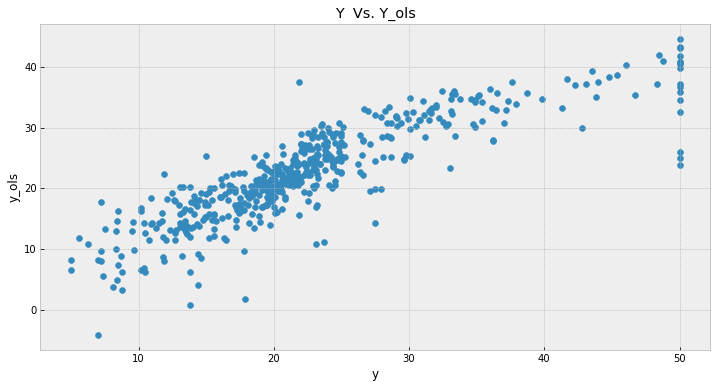

In [4]:
# Plot a scatter plot where on x-axis plot  𝑌  and in the y-axis  𝑌̂ 𝑂𝐿𝑆:
plt.figure(figsize = (12,6))
plt.scatter(y, y_preds)
plt.title('Y  Vs. Y_ols')
plt.xlabel('y')
plt.ylabel('y_ols')
plt.show()

### Create a train and test datasets and predict on both datasets:

In [5]:
#Split the data to 75% train and 25% test 20 times.
from sklearn.model_selection import ShuffleSplit

mse_train = []
mse_test = []

# define shuffle for the randomized cross validation:
rs = ShuffleSplit(n_splits=20, test_size=0.25)

# define model:
ols = Ols()

# Select random indecies and compute score for model:
for train_index, test_index in rs.split(X):
    
    X_train, y_train, X_test, y_test = X[train_index], y[train_index], X[test_index], y[test_index]
    ols.fit(X_train, y_train)
    mse_train.append(ols.score(X_train, y_train))
    mse_test.append(ols.score(X_test, y_test))
    
#What is the average MSE now for train and test?
avg_mse_train = np.mean(mse_train)
avg_mse_test = np.mean(mse_test)
print(f' The average MSE for train is: {round(avg_mse_train,3)}')
print(f' The average MSE for test is: {round(avg_mse_test,3)}')

 The average MSE for train is: 21.501
 The average MSE for test is: 24.404


### Use a t-test to proove that the MSE for training is significantly smaller than for testing.

In [20]:
import scipy.stats
t_stat, p_val = scipy.stats.ttest_rel(mse_train, mse_test)

# What is the p-value?
print(f'We got a p_value of {round(p_val,3)}')
if p_val > 0.05:
    print(f'Since it is greater than 0.05, we cannot reject the null hypothesis that the mean MSE of the training is equal to the testing.')
if p_val <= 0.05:
    print(f'Since it is smaller than 0.05, we can reject the null hypothesis that the mean MSE of the training is equal to the testing.')


We got a p_value of 0.017
Since it is smaller than 0.05, we can reject the null hypothesis that the mean MSE of the training is equal to the testing.


### OlsGd - Ordinary Least Square with gradient descent model:

In [7]:
# A new class OlsGd which solves the problem using gradinet descent. 
# The class gets as a parameter the learning rate and number of iteration. 
class Normalizer():
    def __init__(self):
        pass

    def fit(self, X):
        # compute miu and sigma for standard normalization:
        self.miu = np.mean(X, axis = 0)
        self.sigma = np.std(X, axis = 0)

    def predict(self, X):
        # apply normalization
        return (X - self.miu) / self.sigma
            
class OlsGd(Ols):
  
    def __init__(self, learning_rate=.05, 
               num_iteration=1000, 
               normalize=True,
               early_stop=True,
               verbose=True,
                 
               # Our addition for Ridge regularization:   
               Ridge = False,
               lam = 0.1):
    
        super(OlsGd, self).__init__()
        self.learning_rate = learning_rate
        self.num_iteration = num_iteration
        self.early_stop = early_stop
        self.normalize = normalize
        self.normalizer = Normalizer()    
        self.verbose = verbose
        
        # My addition for Ridge regularization - added later:
        self.Ridge = Ridge
        self.lam = lam
    
    def _fit(self, X, Y, reset=True, track_loss=True):
        # Normalize the data before starting
        if self.normalize:
            self.normalizer.fit(X)
            X = self.normalizer.predict(X)
        
        # and pad X:
        X = self.pad(X)
        
        # reset parameters to zeros if reset is True:
        if reset:
            self.w = np.zeros(X.shape[1])
        # if not initialize randomly: 
        else: 
            self.w = np.random.normal(size = X.shape[1])  
            
        # Compute Loss function:    
        n = Y.shape[0]
        self.L = [self.Loss(X, Y)]
        
        # Run Gradient descent for N iterations: 
        for i in range(self.num_iteration):
            
            # compute grad and update the parameters w:
            self.w = self._step(X,Y)
            
            # append L for future plotting:
            self.L.append(self.Loss(X, Y))
            
            # if verbose is True, print iteration and loss values every 5 iterations:  
            if self.verbose and i%5 == 0:
                print(f'Iteration: {i}, Loss: {self.L[-1]}')

            # define threshold for early stop by loss convergence:         
            eps = 0.01
            
            # Break gradient descent if loss converged: 
            if self.early_stop and self.L[-2]-self.L[-1] < eps:
                break
                
        # print final loss and number of iteration taken. if verbose is True...
        if self.verbose:
            print(f'Final iteration: {i}, Loss: {self.L[-1]}')
            
        # return loss if requested:
        if track_loss:
            return self.L                                                            
                                                              
    def _predict(self, X):
        X = self.normalizer.predict(X)
        return self.predict(X)
      
    def _step(self, X, Y):
        # update w with gradient descent
        if not self.Ridge:
            return self.w - self.learning_rate*(2/n)*np.dot(X.T,(np.dot(X,self.w)-Y))
        # when ridge regularization is true, add term to gradient: 
        else: 
            return self.w - self.learning_rate*(2/n)*(np.dot(X.T,(np.dot(X,self.w)-Y)) + self.lam*self.w)
    
    def _score(self,X,Y):
        return self.L[-1]
        
    def Loss(self, X, Y):
        if not self.Ridge:
            return (1/n)*np.sum((np.dot(X,self.w)-Y)**2)
        # when ridge regularization is true, add term to loss:
        else: 
            return (1/n)*(np.sum((np.dot(X,self.w)-Y)**2) + self.lam * np.sum(self.w**2))
        

### Run the OLS with Gradient descent algorithm with verbose and early stop:

In [8]:
o = OlsGd()
o._fit(X, y, track_loss=False)
y_preds_gd = o._predict(X)

Iteration: 0, Loss: 462.4604490684583
Iteration: 5, Loss: 174.13020491536258
Iteration: 10, Loss: 76.07131291555939
Iteration: 15, Loss: 41.9075010940247
Iteration: 20, Loss: 29.873691975646704
Iteration: 25, Loss: 25.54716199650491
Iteration: 30, Loss: 23.924547492728305
Iteration: 35, Loss: 23.262679096703383
Iteration: 40, Loss: 22.951001395282688
Iteration: 45, Loss: 22.773803923546083
Iteration: 50, Loss: 22.653593646377992
Iteration: 55, Loss: 22.561569307476535
Iteration: 60, Loss: 22.486284298899054
Iteration: 65, Loss: 22.422622954915695
Iteration: 70, Loss: 22.36788878421597
Final iteration: 72, Loss: 22.348097184906386


### Run the algorithm for different alpgas: 

In [9]:
alphas = [0.005, 0.01, 0.05, 0.1]   
Loss = []

for alpha in alphas:
    o = OlsGd(learning_rate=alpha,num_iteration=200, normalize=True, early_stop=False, verbose=False)
    Loss.append(o._fit(X,y))


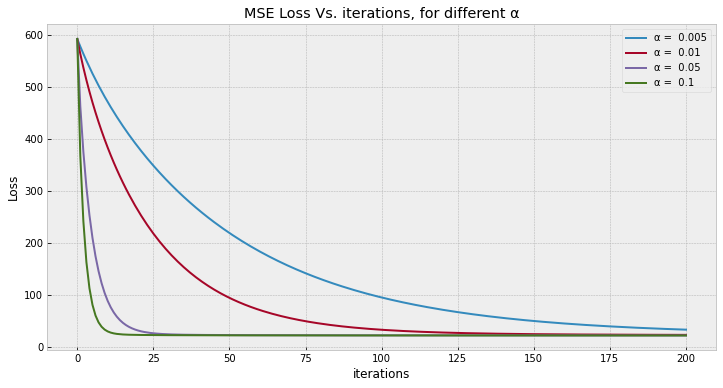

In [10]:
# Plotting:
plt.figure(figsize = (12,6))
for i in range(len(alphas)): 
    plt.plot(Loss[i], label = 'α =  '+ str(alphas[i]))
plt.title('MSE Loss Vs. iterations, for different α')
plt.xlabel('iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

The effect of learning rate - The learning rate is the gain of the step size in the gradient descent. We can see from the graph above, that smaller learning rate causes slow convergence. But, if the learning rate is higher the step might overshoot the minimal loss function, until a slow convergence or, in even larger learning rate values, to divergence. 

How to find number of iteration automatically? - By a stopping criteria. I would like to terminate the algorithm iterations when the loss function converges. Thus, I can define a stopping criteria to the change in the loss function, or the weight or the predicted y's. 
In my solution I used a stopping criteria for the loss function decay. 

### Ridge Linear Regression

Recall that ridge regression is identical to OLS but with a L2 penalty over the weights:

$L(y,\hat{y})=\sum_{i=1}^{i=N}{(y^{(i)}-\hat{y}^{(i)})^2} + \lambda \left\Vert w \right\Vert_2^2$

where $y^{(i)}$ is the **true** value and $\hat{y}^{(i)}$ is the **predicted** value of the $i_{th}$ example, and $N$ is the number of examples



The loss function:
$$ L(y,\hat{y}) = (y− w^{T}X)^{T}(y−w^{T}X)+λw^{T}w $$

$$  => y^{T}y−2w^{T}X^{T}y+w^{T}(X^{T}X+λI)w $$

Derive the loss with respect to the weights: 
$$ \frac{∂L}{∂w} = −2Xy+2(X^{T}X+λI)w = 0 $$

$$ => (X^{T}X+λI)w = X^{T}y $$

$$ \hat{w} = (X^TX+\lambda I)^{-1}X^Ty $$

### Closed form solution with Ridge regression:

In [11]:
# Here the class RidgeLs inherites from the main class ols: 

class RidgeLs(Ols):
    def __init__(self, ridge_lambda, *wargs, **kwargs):
        super(RidgeLs,self).__init__(*wargs, **kwargs)
        self.ridge_lambda = ridge_lambda
    
    def _fit(self, X, Y):
        #Closed form of ridge regression
        
        # pad X with 1 for the bias:
        X = self.pad(X) 
        p = X.shape[1]
        I = np.eye(p)
        
        # The first element on the diagonal suppose to be 0, because we don't regularize the bias term.  
        I[0] = 0
        
        # fit the parameters: 
        self.w = np.dot(np.dot(np.linalg.inv(np.dot(X.T,X) + np.multiply(self.ridge_lambda,I)),X.T),Y)

In [12]:
# Run the closed form solution with Ridge regression: 
R = RidgeLs(ridge_lambda = 1)
R._fit(X,y)
R.score(X,y)

22.044452243088013

In [41]:
# We saw erlier that when we ran this test for the OLS, there was a small variance between the
# train MSE and the test MSE, let's run this test again with the ridge reg algorithm, and see 
# if we can handle the overfitting. 

#Split the data to 75% train and 25% test 20 times.

mse_train = []
mse_test = []

# define shuffle for the randomized cross validation:
rs = ShuffleSplit(n_splits=20,  test_size=0.25)

# define lambda:
ridge_lambda = 0.1

# define model:
R = RidgeLs(ridge_lambda = ridge_lambda)

# Select random indecies and compute score for model:
for train_index, test_index in rs.split(X):
    
    X_train, y_train, X_test, y_test = X[train_index], y[train_index], X[test_index], y[test_index]
    R._fit(X_train, y_train)
    mse_train.append(R.score(X_train, y_train))
    mse_test.append(R.score(X_test, y_test))
    
#What is the average MSE now for train and test?
avg_mse_train = np.mean(mse_train)
avg_mse_test = np.mean(mse_test)
print(f' The average MSE for train is: {round(avg_mse_train,3)}')
print(f' The average MSE for test is: {round(avg_mse_test,3)}')

 The average MSE for train is: 21.988
 The average MSE for test is: 22.926


We can see an imporvement in the variance, the train and the test mse got closer. But since the splits are random, it doesn't accure each time I run the program.  

### OLS with gradient descent and Ridge regression:
As for the Gradient Descent solution for the Ridge regression, I changed the class OlsGd, by adding two 
class inputs: Ridge = True/False, lam = 0.1 (by default). 

As a result I updated the Loss function and step function to add the regularization term in case that Ridge == True. 

Now I will show a sample run of the OlsGd with Ridge regression: 

In [14]:
R_gd = OlsGd(Ridge = True, lam = 0.1)
R_gd._fit(X, y, track_loss = False)

Iteration: 0, Loss: 462.4619020162385
Iteration: 5, Loss: 174.16743852307627
Iteration: 10, Loss: 76.1422407679673
Iteration: 15, Loss: 41.997659223434844
Iteration: 20, Loss: 29.973253404694066
Iteration: 25, Loss: 25.651041882609135
Iteration: 30, Loss: 24.030391603909244
Iteration: 35, Loss: 23.369459054963095
Iteration: 40, Loss: 23.058281284215102
Iteration: 45, Loss: 22.88139983393474
Iteration: 50, Loss: 22.76142545403031
Iteration: 55, Loss: 22.669598740809175
Iteration: 60, Loss: 22.594489816658164
Iteration: 65, Loss: 22.530989796950074
Iteration: 70, Loss: 22.476405116832055
Final iteration: 72, Loss: 22.45667035206966
